# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [593]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [594]:
df = pd.read_csv('../../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [595]:
df = df.astype(int)
# df.head(5)

In [596]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df1 = df[df['DEP_DELAY'] <= 120]
df1 = df1[df1['DEP_DELAY'] >= 15]

df2 = df[df['DEP_DELAY'] >= 0]
df2 = df2[df2['DEP_DELAY'] < 10]

### Outilers Testing

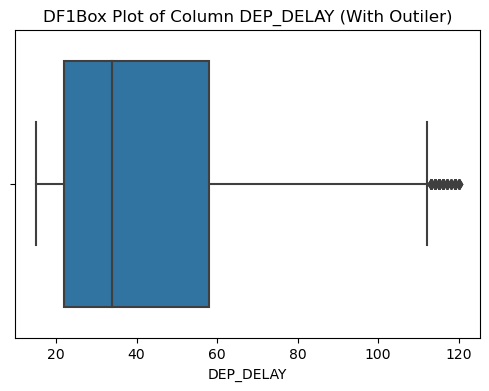

In [597]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df1['DEP_DELAY'])
plt.title("DF1Box Plot of Column DEP_DELAY (With Outiler)")
plt.show()

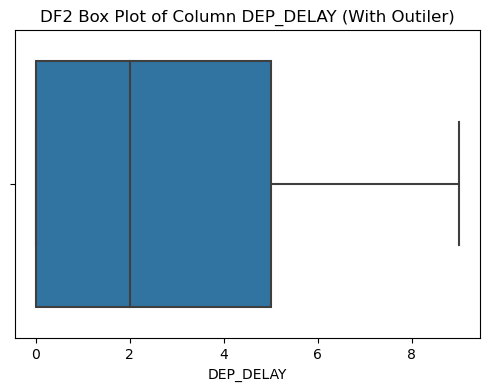

In [598]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df2['DEP_DELAY'])
plt.title("DF2 Box Plot of Column DEP_DELAY (With Outiler)")
plt.show()

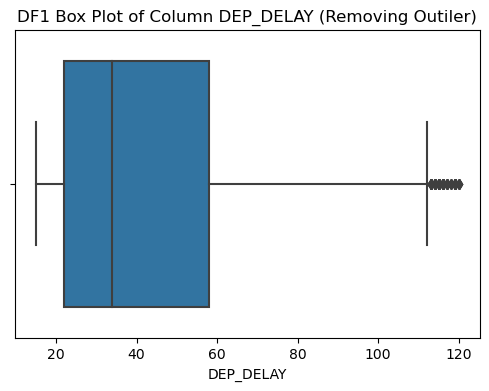

In [599]:
# Compute IQR
Q1 = df1['DEP_DELAY'].quantile(0.25)
Q3 = df1['DEP_DELAY'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# # Compute Mean and Std
# mean = np.mean(df1['DEP_DELAY'])
# std = np.std(df1['DEP_DELAY'])

# upper_bound = mean + (3 * std)
# lower_bound = mean - (3 * std)

# Filter out outliers
df1 = df1[(df1['DEP_DELAY'] >= lower_bound) & (df1['DEP_DELAY'] <= upper_bound)]

# print(df.info())

plt.figure(figsize=(6,4))
sns.boxplot(x=df1['DEP_DELAY'])
plt.title("DF1 Box Plot of Column DEP_DELAY (Removing Outiler)")
plt.show()

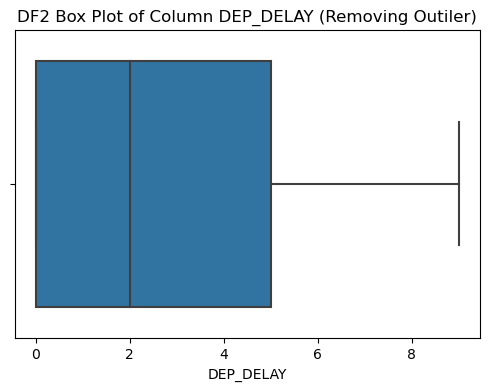

In [600]:
Q1 = df2['DEP_DELAY'].quantile(0.25)
Q3 = df2['DEP_DELAY'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR


# # Compute Mean and Std
# mean = np.mean(df2['DEP_DELAY'])
# std = np.std(df2['DEP_DELAY'])

# upper_bound = mean + (3 * std)
# lower_bound = mean - (3 * std)

# Filter out outliers
df2 = df2[(df2['DEP_DELAY'] >= lower_bound) & (df2['DEP_DELAY'] <= upper_bound)]

# print(df2.info())

plt.figure(figsize=(6,4))
sns.boxplot(x=df2['DEP_DELAY'])
plt.title("DF2 Box Plot of Column DEP_DELAY (Removing Outiler)")
plt.show()

### Transformation Testing

In [601]:
print(f"DEP_DELAY {df1['DEP_DELAY'].skew()}")  # If > 0.5 or < -0.5, transformation is needed

# df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# print(f"DEP_DELAY_shifted {df['DEP_DELAY_shifted'].skew()}")  # If > 0.5 or < -0.5, transformation is needed

df1['DEP_DELAY_log'] = np.log1p(df1['DEP_DELAY'])  # log1p avoids log(0) issue
print(f"DEP_DELAY_log {df1['DEP_DELAY_log'].skew()}")  # If > 0.5 or < -0.5, transformation is needed

print(f"DEP_DELAY {df1['DEP_DELAY'].skew()}")  # If > 0.5 or < -0.5, transformation is needed

# df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# print(f"DEP_DELAY_shifted {df['DEP_DELAY_shifted'].skew()}")  # If > 0.5 or < -0.5, transformation is needed

df2['DEP_DELAY_log'] = np.log1p(df2['DEP_DELAY'])  # log1p avoids log(0) issue
print(f"DEP_DELAY_log {df2['DEP_DELAY_log'].skew()}")  # If > 0.5 or < -0.5, transformation is needed


# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# sns.histplot(df2['DEP_DELAY'], kde=True, ax=axes[0])
# axes[0].set_title('Original')

# sns.histplot(df2['DEP_DELAY_log'], kde=True, ax=axes[1])
# axes[1].set_title('Log Transformed')

# plt.show()

DEP_DELAY 1.0702182191062757
DEP_DELAY_log 0.2952436736852139
DEP_DELAY 1.0702182191062757
DEP_DELAY_log 0.031039951507491996


In [602]:
X = df1.drop(columns=['DEP_DELAY_log', 'DEP_DELAY']) #Dropping DEP_DELAY Log/Sqrt transform cols

# Using Single Log Transformation
y = df1['DEP_DELAY_log']  # Target variable

# X = df2.drop(columns=['DEP_DELAY_log', 'DEP_DELAY']) #Dropping DEP_DELAY Log/Sqrt transform cols

# # Using Single Log Transformation
# y = df2['DEP_DELAY_log']  # Target variable

y.head(3)

2     3.713572
14    4.691348
36    3.401197
Name: DEP_DELAY_log, dtype: float64

### Feature Selection (Post Log Transformation)

In [603]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_26419/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [604]:
k_num_features = 10

In [605]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                    Feature    F-Score
5                   sch_dep  95.170229
6      OP_UNIQUE_CARRIER_DL  32.275147
4                  Pressure  19.850513
9  Condition_Cloudy / Windy  17.777480
0          CRS_ELAPSED_TIME  14.266666
1                  DISTANCE  13.461568
7                  DEST_BOS  10.394094
3                Wind Speed  10.099994
2                 CRS_DEP_M   6.177926
8                  DEST_BUF   5.840659


In [606]:
num_feature_remove = 4

### Log TransFormation

In [607]:
# X['OP_UNIQUE_CARRIER_B6_log'] = np.log1p(X['OP_UNIQUE_CARRIER_B6'])  #Top1  Feature
# X['OP_UNIQUE_CARRIER_DL_log'] = np.log1p(X['OP_UNIQUE_CARRIER_DL'])  #Top2  Feature
# X['CRS_DEP_M_log'] = np.log1p(X['CRS_DEP_M']) #Top3  Feature
# X['CRS_ELAPSED_TIME_log'] = np.log1p(X['CRS_ELAPSED_TIME'])  #Top4 Feature
# X['sch_dep_log'] = np.log1p(X['sch_dep'])  #Top5 Feature 
# X['DISTANCE_log'] = np.log1p(X['DISTANCE'])  #Top6 Feature


# X['sch_dep_log'] = np.log1p(X['sch_dep'])  #Top1 Feature 
# X['DISTANCE_log'] = np.log1p(X['DISTANCE'])  #Top2 Feature
# X['CRS_ELAPSED_TIME_log'] = np.log1p(X['CRS_ELAPSED_TIME'])  #Top3 Feature

# X['OP_UNIQUE_CARRIER_DL_log'] = np.log1p(X['OP_UNIQUE_CARRIER_DL'])  #Top4  Feature
# X['Wind_Speed_log'] = np.log1p(X['Wind Speed'])  #Top5  Feature
# X['CRS_DEP_M_log'] = np.log1p(X['CRS_DEP_M']) #Top6  Feature

# X['Pressure_log'] = np.log1p(X['Pressure']) #Top7  Feature
# X['OP_UNIQUE_CARRIER_MQ_log'] = np.log1p(X['OP_UNIQUE_CARRIER_MQ'])  #Top8  Feature
# X['OP_UNIQUE_CARRIER_B6_log'] = np.log1p(X['OP_UNIQUE_CARRIER_B6'])  #Top9  Feature

# X['Condition_Cloudy / Windy_log'] = np.log1p(X['Condition_Cloudy / Windy'])  #Top10  Feature
# X['DEST_BWI_log'] = np.log1p(X['DEST_BWI'])  #Top11  Feature
# X['DEST_BUF_log'] = np.log1p(X['DEST_BUF'])  #Top12  Feature

# X['DEST_BTV_log'] = np.log1p(X['DEST_BTV'])  #Top13  Feature
# X['DEST_LAX_log'] = np.log1p(X['DEST_LAX'])  #Top14  Feature
# X['DEST_BOS_log'] = np.log1p(X['DEST_BOS'])  #Top15  Feature

### Comparsing F-Score of Log-Feature 
Check Feature Selection F-Score Again

In [608]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features - num_feature_remove # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features (New Comparsion):")
print(feature_df)

Selected Features (New Comparsion):
                    Feature    F-Score
3                   sch_dep  95.170229
4      OP_UNIQUE_CARRIER_DL  32.275147
2                  Pressure  19.850513
5  Condition_Cloudy / Windy  17.777480
0          CRS_ELAPSED_TIME  14.266666
1                  DISTANCE  13.461568


### Split Training and Test Data 80:20

In [609]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 42)

In [610]:
# X_train

In [611]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### KNN Model

In [612]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# from sklearn.neighbors import KNeighborsRegressor
# regressor = KNeighborsRegressor(n_neighbors=9, metric='manhattan', weights='distance')
# # regressor = KNeighborsRegressor(n_neighbors=91, metric='euclidean',  weights='distance')

# regressor.fit(X_train, y_train)

LinearRegression()

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [613]:
y_pred_log = regressor.predict(X_test)

# 1 log transformation
y_pred = np.exp(y_pred_log)
y_test = np.exp(y_test)

In [614]:
# print(y_pred)
# print(y_test)

In [615]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Average Prediction {np.mean(y_pred)}")

# print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 669.40
Mean Absolute Error (MAE): 19.16
Average Prediction 37.7704966769937


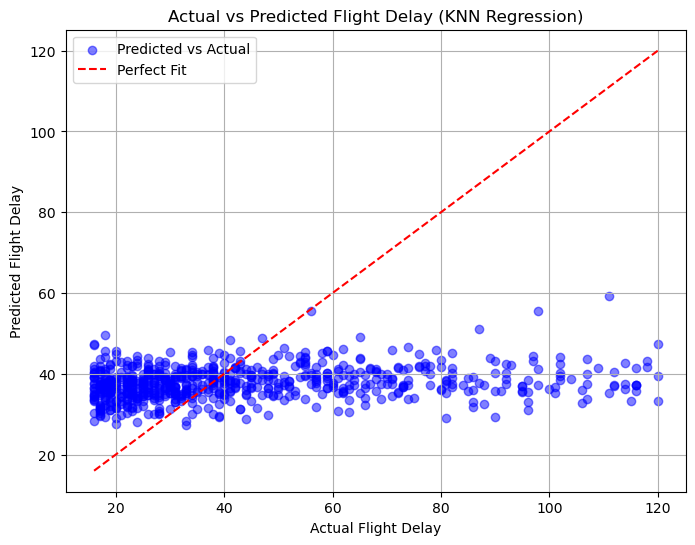

In [616]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [617]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_neighbors': range(3, 21, 2)}
# grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
# grid.fit(X_train, y_train)
# print("Best k:", grid.best_params_)